In [2]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import math
import torch.nn.init as init

In [3]:
def load_data_airfoil():
    data = np.genfromtxt('/home/data/airfoil_self_noise.dat',delimiter='\t')
    data = (data - data.mean(axis=0))/data.std(axis=0)
    features = torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels = torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels
features,labels = load_data_airfoil()
features.shape,labels.shape

(torch.Size([1500, 5]), torch.Size([1500]))

In [12]:
def train_ch7(optimizer_fn,optimizer_hyperparams,features,labels,batch_sizes=10,num_epochs=2):
    net = nn.Sequential(nn.Linear(5,1))
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(),**optimizer_hyperparams)
    data = torch.utils.data.TensorDataset(features,labels)
    data_iter = torch.utils.data.DataLoader(data,batch_sizes,shuffle=True)
    def eval_loss():
        return loss(net(features).view(-1),labels).item()/2
    ls = [eval_loss()]
    for epoch in range(num_epochs):
        start = time.time()
        for batch_i,(X,Y) in enumerate(data_iter):
            y_hat = net(X)
            l = loss(y_hat.view(-1),Y)/2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i+1)*batch_sizes%100==0:
                ls.append(eval_loss())
    print('loss:%f,%f sec per epoch'%(ls[-1],time.time()-start))
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize']=(3,3)
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs:')
    plt.ylabel('loss:')

loss:0.241952,0.173623 sec per epoch


/tmp/ipykernel_906/894893363.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


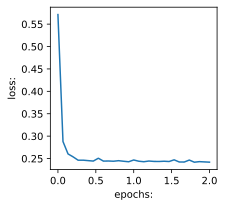

In [13]:
train_ch7(torch.optim.Adagrad,{'lr':0.1},features,labels)

loss:0.244823,0.388581 sec per epoch


/tmp/ipykernel_906/894893363.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


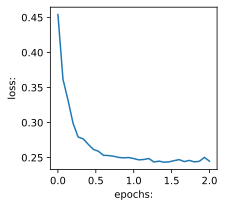

In [16]:
train_ch7(torch.optim.RMSprop,{'lr':0.01,'alpha':0.9},features,labels)


In [ ]:
def init_state_RMSProp():
    r_w =  torch.zeros((features.shape[-1],1),dtype=torch.float32)
    r_b = torch.zeros(1,dtype=torch.float32)
    return r_w,r_b
def RMSProp(params,states,hyperparamers):
    eps = 1e-3
    for p,s in zip(params,states):
        s.data += hyperparamers['gamma']*(p.grada.data**2)
        p.data -= hyperparamers['lr']/torch.sqrt(s**2+eps)*p.grad.data


In [ ]:
def init_state_AdaDelta():
    s_w,s_b = torch.zeros((features.shape[-1],1),dtype=torch.float32),torch.zeros(1,dtype=torch.float32)
    delta_w,delta_b = torch.zeros((features.shape[-1],1),dtype=torch.float32),torch.zeros(1,dtype=torch.float32)

In [ ]:
def AdaDelta(params,states,hyperparams):
    eps = 1e-5
    for p,(s,delta) in zip(params,states):
        s[:] = hyperparams['rho']*s +(1-hyperparams['rho'])*p.grad.data**2
        g = p.grad.data*torch.sqrt((delta+eps)/(s+eps))
        p.data -=g
        delta = hyperparams['rho']*delta +(1-hyperparams['rho'])*g*g


loss:0.243442,0.186436 sec per epoch


/tmp/ipykernel_906/894893363.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


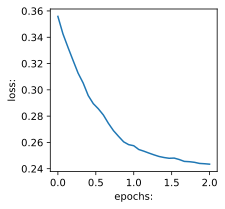

In [18]:
train_ch7(torch.optim.Adadelta,{'rho':0.9},features,labels)


In [ ]:
def init_start_Adam():
    s_w,s_b = torch.zeros((features.shape[-1],1),dtype=torch.float32),torch.zeros(1,dtype=torch.float32)
    v_w,v_b = torch.zeros((features.shape[-1],1),dtype=torch.float32),torch.zeros(1,dtype=torch.float32)
    return (v_w,s_w),(v_b,s_b)

In [ ]:
def Adam(params,starts,hyperparams):
    beta1,beta2,eps = 0.9,0.999,1e-6
    for p,(s,v)in zip(params,starts):
        v = beta1*v+(1-beta1)*p.grad.data
        s = beta2*s +(1-beta2)*p.grad.data
        v_bais_corr = v/(1-beta1**hyperparams['t'])
        s_bais_corr = s/(1-beta2**hyperparams['t'])
        p.data = p.data- (hyperparams['lr']*v_bais_corr/torch.sqrt(s_bais_corr)+eps)
    hyperparams['t'] +=1

loss:0.244843,0.121188 sec per epoch


/tmp/ipykernel_906/894893363.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


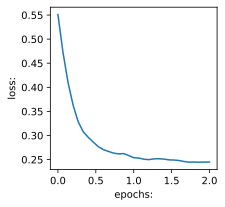

In [19]:
train_ch7(torch.optim.Adam,{'lr':0.01},features,labels)